In [21]:
import pandas as pd
import random
import os
import numpy as np
import torch
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torch.nn.modules.loss import _WeightedLoss
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
import torch.multiprocessing as mp


In [22]:
#read data-set

train_features = pd.read_csv('../dataset/train_features.csv')
test_features = pd.read_csv('../dataset/test_features.csv')
train_targets_scored = pd.read_csv('../dataset/train_targets_scored.csv')
sample_submission = pd.read_csv('../dataset/sample_submission.csv')

GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]


In [23]:
for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [24]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# PCA features

In [25]:
# GENES
n_comp_GENES = 450
n_comp_CELLS = 45
VarianceThreshold_for_FS = 0.67

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [26]:
data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [27]:
# create train-set, test-set and targets
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target_cols = target.drop('sig_id', axis=1).columns.values.tolist()


In [28]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

def plot_labels(x_dict): 
    x = {k: v for k, v in sorted(x_dict.items(), key=lambda item: item[1], reverse=True)}
    keys = x.keys()
    vals = x.values()

    font = {'family': 'serif',
            'color':  'green',
            'weight': 'normal',
            'size': 16,
            }
    fig, ax = plt.subplots(figsize=(35, 10))
    plt.bar(keys, vals)
    plt.title('MoA Scored Labels ',fontdict=font)
    plt.ylabel ('Counts')
    plt.xlabel ('Labels')
    plt.xticks(list(keys))
    # plt.
    plt.show()

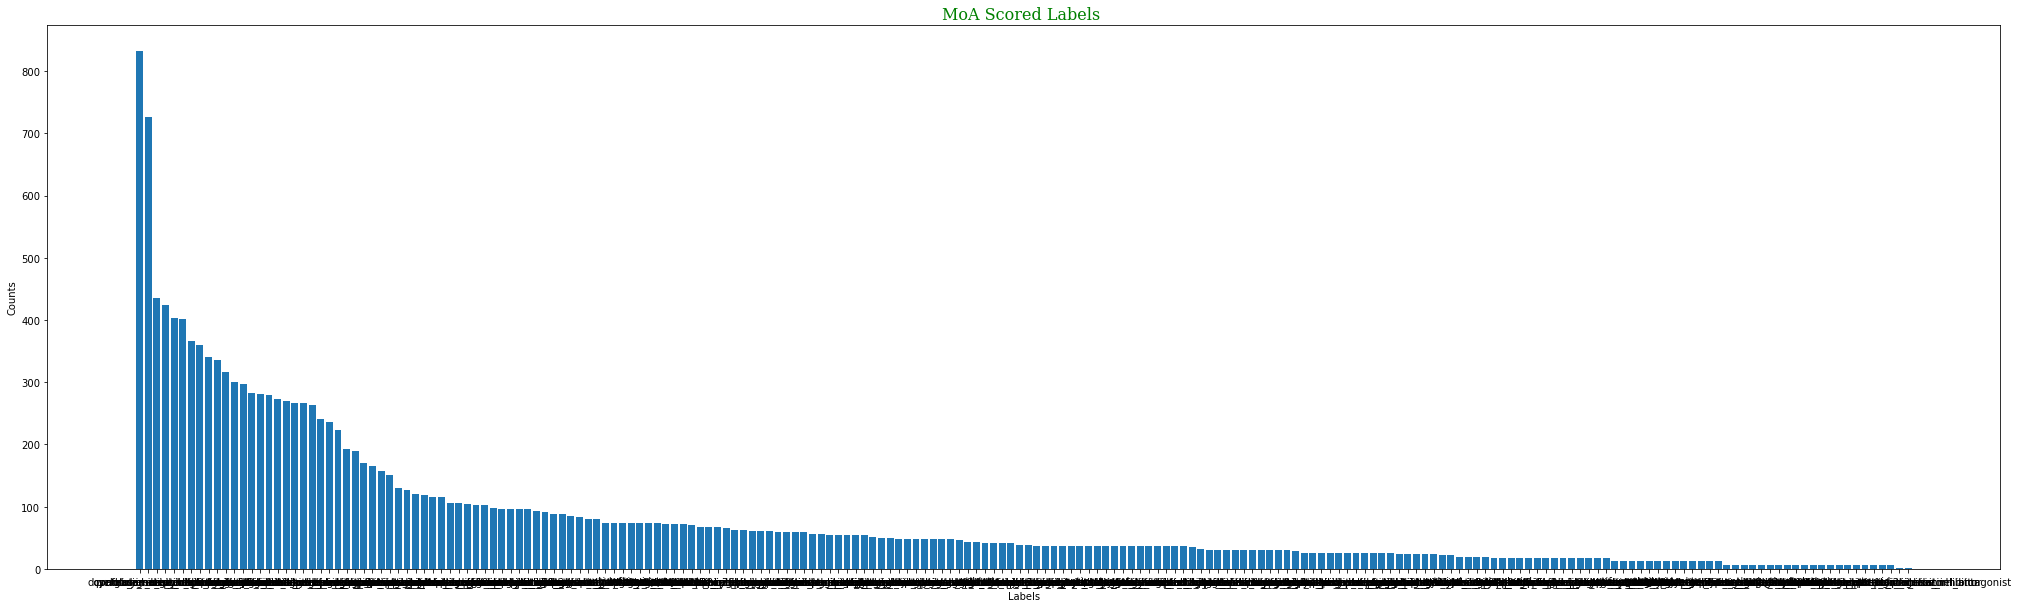

0.5


In [29]:
plot_labels(train_targets_scored[target_cols].sum().to_dict())
s = train_targets_scored[target_cols].sum()
maxs = max(s)
s = s / maxs
s = s.to_list()
out_w = [1.5 - s for s in s]
# out_w = [1 - s*0.5 for s in s]
print(min(out_w))

In [30]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sig_id  cp_time cp_dose       g-0       g-1       g-2       g-3  \
0      id_000644bb2       24      D1  1.134849  0.907687 -0.416385 -0.966814   
1      id_000779bfc       72      D1  0.119282  0.681738  0.272399  0.080113   
2      id_000a6266a       48      D1  0.779973  0.946463  1.425350 -0.132928   
3      id_0015fd391       48      D1 -0.734910 -0.274641 -0.438509  0.759097   
4      id_001626bd3       72      D2 -0.452718 -0.477513  0.972316  0.970731   
...             ...      ...     ...       ...       ...       ...       ...   
21943  id_fff8c2444       72      D1  0.237856 -1.228203  0.218376 -0.365976   
21944  id_fffb1ceed       24      D2  0.209361 -0.022389 -0.235888 -0.796989   
21945  id_fffb70c0c       24      D2 -1.911021  0.587228 -0.588417  1.296405   
21946  id_fffcb9e7c       24      D1  0.816407  0.417618  0.431631  0.300617   
21947  id_ffffdd77b       72      D1 -1.243096  1.567730 -0.269573  1.083636   

            g-4       g-5       g-6  ...  trpv_agonist  trpv_antagonist  \
0     -0.254723 -1.017473 -1.364787  ...             0                0   
1      1.205169  0.686517  0.313396  ...             0                0   
2     -0.006122  1.492493  0.235577  ...             0                0   
3      2.346330 -0.858153 -2.288417  ...             0                0   
4      1.463427 -0.869555 -0.375501  ...             0                0   
...         ...       ...       ...  ...           ...              ...   
21943 -0.330177  0.569243 -0.150978  ...             0                0   
21944 -0.674009  0.919312  0.735603  ...             0                0   
21945 -1.002640  0.850589 -0.304313  ...             0                0   
21946  1.070346 -0.024189  0.048942  ...             0                0   
21947 -0.511235 -2.099634 -1.622462  ...             0                0   

       tubulin_inhibitor  tyrosine_kinase_inhibitor  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   
...                  ...                        ...   
21943                  0                          0   
21944                  0                          0   
21945                  0                          0   
21946                  0                          0   
21947                  0                          0   

       ubiquitin_specific_protease_inhibitor  vegfr_inhibitor  vitamin_b  \
0                                          0                0          0   
1                                          0                0          0   
2                                          0                0          0   
3                                          0                0          0   
4                                          0                0          0   
...                                      ...              ...        ...   
21943                                      0                0          0   
21944                                      0                0          0   
21945                                      0                0          0   
21946                                      0                0          0   
21947                                      0                0          0   

       vitamin_d_receptor_agonist  wnt_inhibitor  kfold  
0                               0              0      5  
1                               0              0      0  
2                               0              0      6  
3                               0              0      0  
4                               0              0      4  
...                           ...            ...    ...  
21943                           0              0      5  
21944                           0              0      1  
21945                           0              0      5

In [31]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [32]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].cuda(device), data['y'].cuda(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].cuda(device), data['y'].cuda(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].cuda(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds


In [33]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Preprocessing

In [34]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

1372

# Modeling

In [35]:
# HyperParameters

# DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
# EPOCHS = 30
# BATCH_SIZE = 128
# LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 1e-5
# NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)

# hidden_size=num_targets*4
# lstm_size=num_targets*4


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [36]:
# out_w = torch.cuda.FloatTensor(out_w)
# a=torch.cuda.FloatTensor()
# len(feature_cols)

In [37]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size, lstm_size, dropout, dropout_rnn):
        super(Model, self).__init__()
        
        self.lstm1 = nn.GRU(num_features, lstm_size, num_layers=1, dropout=dropout_rnn, bidirectional=True)

        self.batch_norm1 = nn.BatchNorm1d(lstm_size*2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(lstm_size*2, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout) # Update
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, int(hidden_size)))
        
        self.batch_norm3 = nn.BatchNorm1d(int(hidden_size))
        self.dropout3 = nn.Dropout(dropout) # Update
        self.dense3 = nn.utils.weight_norm(nn.Linear(int(hidden_size), num_targets))
    
    def forward(self, inp):
        
        lstm_out, _ = self.lstm1(inp.view(len(inp), 1, -1))
        
        
        x = self.batch_norm1(lstm_out.view(len(inp), -1))
        x = F.leaky_relu(self.dense1(lstm_out.view(len(inp), -1)))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

# class Model(nn.Module):
#     def __init__(self, num_features, num_targets, hidden_size, lstm_size, dropout, dropout_rnn):
#         super(Model, self).__init__()
        
#         self.lstm1 = nn.GRU(num_features, lstm_size, num_layers=1, dropout=dropout_rnn, bidirectional=True)

#         self.batch_norm1 = nn.BatchNorm1d(lstm_size*2)
#         self.dense1 = nn.utils.weight_norm(nn.Linear(lstm_size*2, hidden_size))
        
#         self.batch_norm2 = nn.BatchNorm1d(hidden_size)
#         self.dropout2 = nn.Dropout(dropout) # Update
#         self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, int(hidden_size/2)))
        
#         self.batch_norm3 = nn.BatchNorm1d(int(hidden_size/2))
#         self.dropout3 = nn.Dropout(dropout) # Update
#         self.dense3 = nn.utils.weight_norm(nn.Linear(int(hidden_size/2), num_targets))
    
#     def forward(self, inp):
        
#         lstm_out, _ = self.lstm1(inp.view(len(inp), 1, -1))
        
        
#         x = self.batch_norm1(lstm_out.view(len(inp), -1))
#         x = F.leaky_relu(self.dense1(lstm_out.view(len(inp), -1)))
        
#         x = self.batch_norm2(x)
#         x = self.dropout2(x)
#         x = F.leaky_relu(self.dense2(x))
        
#         x = self.batch_norm3(x)
#         x = self.dropout3(x)
#         x = self.dense3(x)
        
#         return x

# class Model(nn.Module):
#     def __init__(self, num_features, num_targets, hidden_size):
#         super(Model, self).__init__()
#         self.batch_norm1 = nn.BatchNorm1d(num_features)
#         self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
#         self.batch_norm2 = nn.BatchNorm1d(hidden_size)
#         self.dropout2 = nn.Dropout(0.25) # Update
#         self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
#         self.batch_norm3 = nn.BatchNorm1d(hidden_size)
#         self.dropout3 = nn.Dropout(0.25) # Update
#         self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
#     def forward(self, x):
#         x = self.batch_norm1(x)
#         x = F.leaky_relu(self.dense1(x))
        
#         x = self.batch_norm2(x)
#         x = self.dropout2(x)
#         x = F.leaky_relu(self.dense2(x))
        
#         x = self.batch_norm3(x)
#         x = self.dropout3(x)
#         x = self.dense3(x)
        
#         return x


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))   

# # Run training

In [38]:
from torchsummary import summary
# EPOCHS = 30
# BATCH_SIZE = 128
# LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 1e-5
# NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)

# hidden_size=num_targets*4
# lstm_size=num_targets*4

def run_training(fold, seed, device_k, EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, lstm_size, hidden_size, dropout, dropout_rnn):
    
    seed_everything(seed)
    
    out_w_tensor = torch.FloatTensor(out_w).cuda(device_k) #torch.cuda.FloatTensor(out_w)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
        lstm_size=lstm_size,
        dropout=dropout, 
        dropout_rnn=dropout_rnn
    )
    
    
    model.cuda(device_k)
    
    # summary(model, input_size=(1,num_features))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001, weight=out_w_tensor)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    #vis_tr = Visualizations()
    #vis_val = Visualizations
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, device_k)
        # print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, device_k)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        #vis_tr.plot_loss(train_loss, step=epoch)
        #vis_val.plot_loss(valid_loss, step=epoch)
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_gpu{device_k}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    del model
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
        lstm_size=lstm_size,
        dropout=dropout, 
        dropout_rnn=dropout_rnn

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_gpu{device_k}_.pth"))
    model.cuda(device_k)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, device_k)
    
    del model
    
    return oof, predictions

In [39]:
def run_k_fold(LEARNING_RATE, WEIGHT_DECAY, lstm_size, hidden_size, dropout, dropout_rnn, NFOLDS=7, EPOCHS=30, BATCH_SIZE=128, seed=122):
    NFOLDS = int(NFOLDS)
    EPOCHS = int(EPOCHS)
    BATCH_SIZE = int(BATCH_SIZE)
    lstm_size = int(lstm_size)
    hidden_size = int(hidden_size)
    
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed, 1, EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, lstm_size, hidden_size, dropout, dropout_rnn)
        
        predictions += pred_ / NFOLDS
        oof += oof_
    
    train[target_cols] = oof
    test[target_cols] = predictions

    valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

    y_true = train_targets_scored[target_cols].values
    y_pred = valid_results[target_cols].values

    score = 0
    for i in range(len(target_cols)):
        score_ = log_loss(y_true[:, i], y_pred[:, i])
        score += score_ / target.shape[1]
    
    # torch.cuda.empty_cache()
    
    print("CV log_loss: ", score)  
    
    return -score

In [40]:
params = {"LEARNING_RATE": 0.023153596200219027, "WEIGHT_DECAY": 7.577044272158653e-06, "dropout": 0.13438812081350468, "dropout_rnn": 0.21372479794113872, "hidden_size": 1108.958121738317, "lstm_size": 513.4933834621893}
run_k_fold(LEARNING_RATE=110*1e-4, WEIGHT_DECAY=1e-5, lstm_size=num_features, hidden_size=num_features, dropout=0.25, dropout_rnn=0.25, NFOLDS=7, EPOCHS=30, BATCH_SIZE=128, seed=122)
#run_k_fold(NFOLDS=7, EPOCHS=30, BATCH_SIZE=128, seed=122, **params)

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 0, EPOCH: 0, valid_loss: 0.0356176421046257
FOLD: 0, EPOCH: 1, valid_loss: 0.020306806191802026
FOLD: 0, EPOCH: 2, valid_loss: 0.022282854691147803
FOLD: 0, EPOCH: 3, valid_loss: 0.019945732802152633
FOLD: 0, EPOCH: 4, valid_loss: 0.01877529755234718
FOLD: 0, EPOCH: 5, valid_loss: 0.018619356900453566
FOLD: 0, EPOCH: 6, valid_loss: 0.018103206902742384
FOLD: 0, EPOCH: 7, valid_loss: 0.018212694600224497
FOLD: 0, EPOCH: 8, valid_loss: 0.01796104695647955
FOLD: 0, EPOCH: 9, valid_loss: 0.018504610508680342
FOLD: 0, EPOCH: 10, valid_loss: 0.017877346388995647
FOLD: 0, EPOCH: 11, valid_loss: 0.01773838561028242
FOLD: 0, EPOCH: 12, valid_loss: 0.017892886064946652
FOLD: 0, EPOCH: 13, valid_loss: 0.0178203547000885
FOLD: 0, EPOCH: 14, valid_loss: 0.017809530571103096
FOLD: 0, EPOCH: 15, valid_loss: 0.017475128881633283
FOLD: 0, EPOCH: 16, valid_loss: 0.017467454113066196
FOLD: 0, EPOCH: 17, valid_loss: 0.018332551792263986
FOLD: 0, EPOCH: 18, valid_loss: 0.017406951934099198
FOLD: 0, E

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 1, EPOCH: 0, valid_loss: 0.034689712524414065
FOLD: 1, EPOCH: 1, valid_loss: 0.020092542320489883
FOLD: 1, EPOCH: 2, valid_loss: 0.019551753476262094
FOLD: 1, EPOCH: 3, valid_loss: 0.01803506098687649
FOLD: 1, EPOCH: 4, valid_loss: 0.01785267874598503
FOLD: 1, EPOCH: 5, valid_loss: 0.01753933873027563
FOLD: 1, EPOCH: 6, valid_loss: 0.017368193976581098
FOLD: 1, EPOCH: 7, valid_loss: 0.01761124435812235
FOLD: 1, EPOCH: 8, valid_loss: 0.017577368170022964
FOLD: 1, EPOCH: 9, valid_loss: 0.017561409287154675
FOLD: 1, EPOCH: 10, valid_loss: 0.01758527334779501
FOLD: 1, EPOCH: 11, valid_loss: 0.017689443863928317
FOLD: 1, EPOCH: 12, valid_loss: 0.017893083617091177
FOLD: 1, EPOCH: 13, valid_loss: 0.017760958634316922
FOLD: 1, EPOCH: 14, valid_loss: 0.017539653964340686
FOLD: 1, EPOCH: 15, valid_loss: 0.017940795943140984
FOLD: 1, EPOCH: 16, valid_loss: 0.017295394353568555
FOLD: 1, EPOCH: 17, valid_loss: 0.017679637521505354
FOLD: 1, EPOCH: 18, valid_loss: 0.01753939740359783
FOLD: 1, 

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 2, EPOCH: 0, valid_loss: 0.03389976434409618
FOLD: 2, EPOCH: 1, valid_loss: 0.020268248021602632
FOLD: 2, EPOCH: 2, valid_loss: 0.019054158851504327
FOLD: 2, EPOCH: 3, valid_loss: 0.019485074020922186
FOLD: 2, EPOCH: 4, valid_loss: 0.01887976847589016
FOLD: 2, EPOCH: 5, valid_loss: 0.017794646956026554
FOLD: 2, EPOCH: 6, valid_loss: 0.01759867213666439
FOLD: 2, EPOCH: 7, valid_loss: 0.017986330911517145
FOLD: 2, EPOCH: 8, valid_loss: 0.017722021527588366
FOLD: 2, EPOCH: 9, valid_loss: 0.01799413051456213
FOLD: 2, EPOCH: 10, valid_loss: 0.01767205886542797
FOLD: 2, EPOCH: 11, valid_loss: 0.017710037268698214
FOLD: 2, EPOCH: 12, valid_loss: 0.017602041214704513
FOLD: 2, EPOCH: 13, valid_loss: 0.01801382105797529
FOLD: 2, EPOCH: 14, valid_loss: 0.017931566163897513
FOLD: 2, EPOCH: 15, valid_loss: 0.017654363363981247
FOLD: 2, EPOCH: 16, valid_loss: 0.017395532727241515
FOLD: 2, EPOCH: 17, valid_loss: 0.01742434088140726
FOLD: 2, EPOCH: 18, valid_loss: 0.017544733211398125
FOLD: 2, E

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 3, EPOCH: 0, valid_loss: 0.03421907424926758
FOLD: 3, EPOCH: 1, valid_loss: 0.019967051520943642
FOLD: 3, EPOCH: 2, valid_loss: 0.02053651452064514
FOLD: 3, EPOCH: 3, valid_loss: 0.019212230667471887
FOLD: 3, EPOCH: 4, valid_loss: 0.018418882116675375
FOLD: 3, EPOCH: 5, valid_loss: 0.0180329592525959
FOLD: 3, EPOCH: 6, valid_loss: 0.01817747712135315
FOLD: 3, EPOCH: 7, valid_loss: 0.017868219166994093
FOLD: 3, EPOCH: 8, valid_loss: 0.017908886000514032
FOLD: 3, EPOCH: 9, valid_loss: 0.01786078408360481
FOLD: 3, EPOCH: 10, valid_loss: 0.017993791699409484
FOLD: 3, EPOCH: 11, valid_loss: 0.017854653522372244
FOLD: 3, EPOCH: 12, valid_loss: 0.017865559682250023
FOLD: 3, EPOCH: 13, valid_loss: 0.017763009518384932
FOLD: 3, EPOCH: 14, valid_loss: 0.017721482440829276
FOLD: 3, EPOCH: 15, valid_loss: 0.017851362004876137
FOLD: 3, EPOCH: 16, valid_loss: 0.01753372646868229
FOLD: 3, EPOCH: 17, valid_loss: 0.017362562753260136
FOLD: 3, EPOCH: 18, valid_loss: 0.017293912842869758
FOLD: 3, E

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 4, EPOCH: 0, valid_loss: 0.03379826709628105
FOLD: 4, EPOCH: 1, valid_loss: 0.020169653445482254
FOLD: 4, EPOCH: 2, valid_loss: 0.01827859379351139
FOLD: 4, EPOCH: 3, valid_loss: 0.02079555846750736
FOLD: 4, EPOCH: 4, valid_loss: 0.019556834548711776
FOLD: 4, EPOCH: 5, valid_loss: 0.018562554866075515
FOLD: 4, EPOCH: 6, valid_loss: 0.018106242418289186
FOLD: 4, EPOCH: 7, valid_loss: 0.018070824593305588
FOLD: 4, EPOCH: 8, valid_loss: 0.018192562684416772
FOLD: 4, EPOCH: 9, valid_loss: 0.017856151163578034
FOLD: 4, EPOCH: 10, valid_loss: 0.017762625142931938
FOLD: 4, EPOCH: 11, valid_loss: 0.017826348915696143
FOLD: 4, EPOCH: 12, valid_loss: 0.018098717331886293
FOLD: 4, EPOCH: 13, valid_loss: 0.017811916247010232
FOLD: 4, EPOCH: 14, valid_loss: 0.017621486335992812
FOLD: 4, EPOCH: 15, valid_loss: 0.01786892056465149
FOLD: 4, EPOCH: 16, valid_loss: 0.017529689893126487
FOLD: 4, EPOCH: 17, valid_loss: 0.017420118488371373
FOLD: 4, EPOCH: 18, valid_loss: 0.017485185638070107
FOLD: 4

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 5, EPOCH: 0, valid_loss: 0.0338692282140255
FOLD: 5, EPOCH: 1, valid_loss: 0.020123004764318466
FOLD: 5, EPOCH: 2, valid_loss: 0.021063345149159432
FOLD: 5, EPOCH: 3, valid_loss: 0.02580430194735527
FOLD: 5, EPOCH: 4, valid_loss: 0.018772673681378364
FOLD: 5, EPOCH: 5, valid_loss: 0.0183450572937727
FOLD: 5, EPOCH: 6, valid_loss: 0.018017552867531775
FOLD: 5, EPOCH: 7, valid_loss: 0.017965090572834016
FOLD: 5, EPOCH: 8, valid_loss: 0.017822388634085654
FOLD: 5, EPOCH: 9, valid_loss: 0.017800682932138445
FOLD: 5, EPOCH: 10, valid_loss: 0.01791842944920063
FOLD: 5, EPOCH: 11, valid_loss: 0.01776047468185425
FOLD: 5, EPOCH: 12, valid_loss: 0.01772936649620533
FOLD: 5, EPOCH: 13, valid_loss: 0.017779280468821525
FOLD: 5, EPOCH: 14, valid_loss: 0.01796819731593132
FOLD: 5, EPOCH: 15, valid_loss: 0.018255470544099806
FOLD: 5, EPOCH: 16, valid_loss: 0.01754459150135517
FOLD: 5, EPOCH: 17, valid_loss: 0.017718020528554916
FOLD: 5, EPOCH: 18, valid_loss: 0.017314591854810716
FOLD: 5, EPOC

/home/adrian/anaconda3/envs/2n-hacks-2020/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


FOLD: 6, EPOCH: 0, valid_loss: 0.03659843116998673
FOLD: 6, EPOCH: 1, valid_loss: 0.02053722344338894
FOLD: 6, EPOCH: 2, valid_loss: 0.020441261529922487
FOLD: 6, EPOCH: 3, valid_loss: 0.018385996371507646
FOLD: 6, EPOCH: 4, valid_loss: 0.01804494597017765
FOLD: 6, EPOCH: 5, valid_loss: 0.01774188056588173
FOLD: 6, EPOCH: 6, valid_loss: 0.017718365304172038
FOLD: 6, EPOCH: 7, valid_loss: 0.017613775804638864
FOLD: 6, EPOCH: 8, valid_loss: 0.01805160943418741
FOLD: 6, EPOCH: 9, valid_loss: 0.017638739719986914
FOLD: 6, EPOCH: 10, valid_loss: 0.018256835117936136
FOLD: 6, EPOCH: 11, valid_loss: 0.017631719782948495
FOLD: 6, EPOCH: 12, valid_loss: 0.017618022598326205
FOLD: 6, EPOCH: 13, valid_loss: 0.01770242001861334
FOLD: 6, EPOCH: 14, valid_loss: 0.01803342517465353
FOLD: 6, EPOCH: 15, valid_loss: 0.017645420394837855
FOLD: 6, EPOCH: 16, valid_loss: 0.017578427866101264
FOLD: 6, EPOCH: 17, valid_loss: 0.017448544688522815
FOLD: 6, EPOCH: 18, valid_loss: 0.0172139485925436
FOLD: 6, EPO

-0.014981442502601468

In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

#0.014969637304200012
#0.014950520815970245
#0.014981442502601468

# optimizer = BayesianOptimization(
    f=run_k_fold,
    pbounds={'LEARNING_RATE': (1e-4, 1e-1), 'WEIGHT_DECAY': (1e-8, 1e-4),
             'lstm_size': (num_features/8, num_features), 'hidden_size': (num_targets/2, num_targets*8),
             'dropout': (0.1, 0.5), 'dropout_rnn': (0.1, 0.5)},
    # verbose=2,
    random_state=1,
)

logger = JSONLogger(path="../logs.json")
optimizer.subscribe(Events.Events.OPTIMIZATION_START, logger)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.probe(
    params={'LEARNING_RATE': 1e-3, 'WEIGHT_DECAY': 1e-5,
             'lstm_size': num_targets*4, 'hidden_size': num_targets*4,
             'dropout': 0.25, 'dropout_rnn': 0.25},
    lazy=True,
)
# optimizer.maximize(n_iter=100, acq="ucb", kappa=10)

#tility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

#for _ in range(50):
#   next_point = optimizer.suggest(utility)
#   target = run_k_fold(**next_point)
#   optimizer.register(params=next_point, target=target)   
#   print(target, next_point)

# print(optimizer.max)
# print(optimizer.min)





# Submission

In [ ]:
#sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
#sub.to_csv('submission' + str(score) + '.csv', index=False)

In [ ]:
num_features/8

In [ ]:
num_features

In [ ]:
num_targets*4

In [ ]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except: pass